## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [1]:
# I would like to acknowledge use of CHATGPT as aid in completing this assignment. It was of particular aid in helping me understand the intuition behind PCA.
!git clone "https://github.com/ds3001f25/pca_assignment"

Cloning into 'pca_assignment'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 7 (from 1)
Receiving objects: 100% (9/9), 1.54 MiB | 9.41 MiB/s, done.


In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
with open('/content/pca_assignment/data/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

#Count Token Frequency
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

print(token_freq)

[('new', 1365), ('date', 1202), ('get', 1052), ('please', 1022), ('enron', 927), ('like', 923), ('2002', 869), ('would', 806), ('one', 798), ('message', 795), ('call', 740), ('free', 691), ('software', 680), ('dear', 651), ('know', 644), ('email', 629), ('url:', 625), ('time', 609), ('start', 604), ('linguistics', 598), ('online', 591), ('need', 587), ('wrote:', 585), ('see', 554), ('conference', 553), ('language', 550), ('want', 548), ('empty', 546), ('hourahead', 526), ('list', 523), ('attached', 515), ('hello', 501), ('university', 500), ('2001', 489), ('information', 473), ('vince', 473), ('may', 461), ('good', 449), ('following', 448), ('hour', 446), ('2000', 442), ('business', 442), ('save', 423), ('first', 423), ('click', 423), ('best', 423), ('make', 421), ('com', 413), ('original', 410), ('offer', 405), ('meeting', 403), ('thanks', 397), ('mail', 395), ('use', 389), ('find', 386), ('papers', 383), ('http', 378), ('sent', 375), ('available', 373), ('last', 372), ('update', 363)

Plot a histogram of the occurrences of tokens.

What do you notice about the frequency of occurrence of different tokens? How does it look?

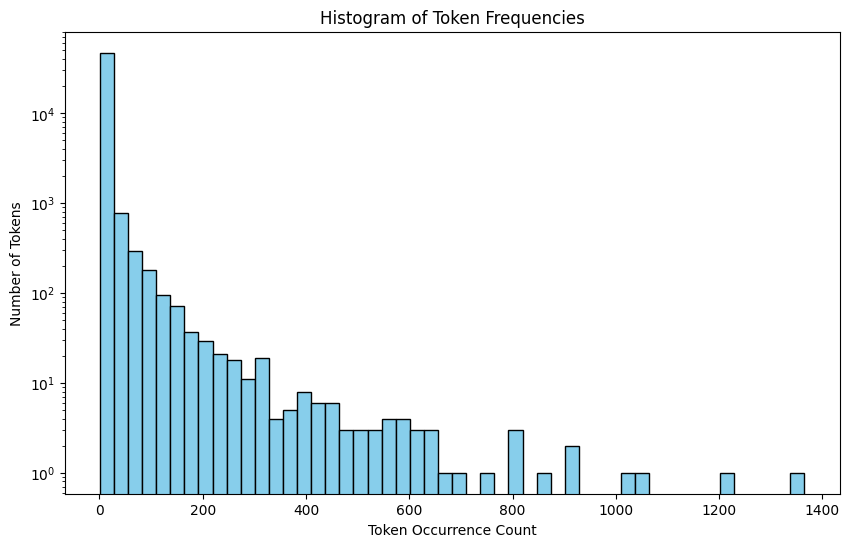

In [3]:
#Q1 Extract  the frequencies and then plot them in a histogram
freq_values = [count for token, count in token_freq]

plt.figure(figsize=(10, 6))
plt.hist(freq_values, bins=50, color='skyblue', edgecolor='black')
plt.yscale('log')  # Helps visualize the long tail
plt.title("Histogram of Token Frequencies")
plt.xlabel("Token Occurrence Count")
plt.ylabel("Number of Tokens")
plt.show()

#Q1

The frequency of the tokens present in the histogram tells us that the data is scewed heavily towards a certain number of tokens/words highlighted by a steep drop off as the token occurrence count increases. This makes sense because emails and their syntax is very similar liguistically.

### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [4]:
#Q2 Reading parquet data
df=pd.read_parquet('/content/pca_assignment/data/Phishing_clean.parquet')

X = df.drop(columns=['Email Type'])
y = df['Email Type']

 Performing 80/20 Train-test split of data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

 Running regresssion of y on the hot-encoded emails
# Fit linear regression
reg = LinearRegression()
reg.fit(X_train, y_train)

# Predict
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

# Compute R^2
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R² (train): {r2_train:.4f}")
print(f"R² (test): {r2_test:.4f}")


#The R² on the training set is .7670 and  The R² on the testing set is .6659.



R² (train): 0.7670
R² (test): 0.6659


#The $R^2$ on the training set is .7670 and  The $R²$ on the testing set is .6659.


In [5]:
#3. Getting coefficient values and corresponding token names
coef_df = pd.DataFrame({
    'token': X.columns,
    'coef': reg.coef_
})

# Sort by absolute coefficient
coef_df['abs_coef'] = np.abs(coef_df['coef'])
top_tokens = coef_df.sort_values(by='abs_coef', ascending=False).head(10)

top_tokens

,token,coef,abs_coef
835,intervention,-1.259257,1.259257
740,localized,0.824350,0.824350
2362,thermal,0.747006,0.747006
851,crawler,0.696167,0.696167
1504,background-image:,-0.622909,0.622909
1406,"helvetica,",0.598560,0.598560
906,aging,0.594956,0.594956
1839,form.,0.576886,0.576886
2242,gray;,-0.574480,0.574480
1552,a:active,0.574480,0.574480


#3 The words with the highest beta coefficients are "intervention, localized, thermal, crawler, background-image:, helvetica, aging, form., gray:, and a:active.

### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

In [6]:
# Q3
scaler = StandardScaler(with_mean=False)  # with_mean=False required for sparse or 0/1 data
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)

pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Email Type': y
})

Explained variance ratio: [0.00458126 0.00419643]


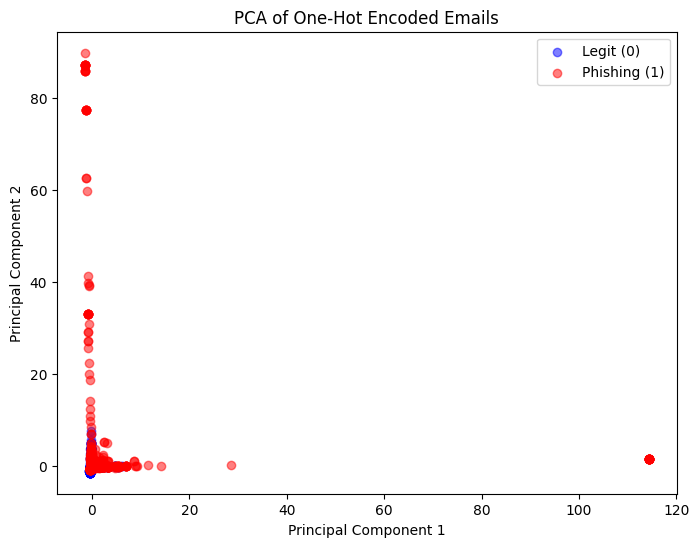

In [7]:
#Q3 Plotting Phising Scams vs Legit Emails with 2 Components of PCA
plt.figure(figsize=(8,6))
plt.scatter(
    pca_df.loc[y==0, 'PC1'], pca_df.loc[y==0, 'PC2'],
    alpha=0.5, label='Legit (0)', color='blue'
)
plt.scatter(
    pca_df.loc[y==1, 'PC1'], pca_df.loc[y==1, 'PC2'],
    alpha=0.5, label='Phishing (1)', color='red'
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of One-Hot Encoded Emails')
plt.legend()
plt.show()

**Q3 Interpretation**-

The scatterplot displays that most points (emails) are centered around the origin, however phising emails tend to have more variation in principal component two than legit emails. This is because phishing emails do share relatively similar linguistic properties to legit emails, and thats why they have similar variation in principal component one. However, variation in principal component two does indentify differences in between the two types of emails, probably tracing back to wording or phrases that are of a second tier of importance but enough to distinct between phisining email vs legit.

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [8]:
#Q4
# Standardize (important before PCA)
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA reduction
pca = PCA(n_components=2610, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Explained variance ratio sum: {pca.explained_variance_ratio_.sum():.4f}")

reg_pca = LinearRegression()
reg_pca.fit(X_train_pca, y_train)

# Predictions
y_train_pred_pca = reg_pca.predict(X_train_pca)
y_test_pred_pca = reg_pca.predict(X_test_pca)

# R² scores
r2_train_pca = r2_score(y_train, y_train_pred_pca)
r2_test_pca = r2_score(y_test, y_test_pred_pca)

print(f"PCA Regression R² (train): {r2_train_pca:.4f}")
print(f"PCA Regression R² (test): {r2_test_pca:.4f}")


Explained variance ratio sum: 0.9997
PCA Regression R² (train): 0.7661
PCA Regression R² (test): 0.6684


**Q4**

The PCA Regression R² for the training set is : 0.7661
The PCA Regression R² for the testing set is : 0.6684

This performance is almost identical to that of the linear regresion in terms of $R^2$. Both training sets have $R^2$ that hover around .766, and both testing sets hover around .669. However, the differences come within the explained variance ratio. The explained variance ratio with 2610 components covers 99.7% of the total variance, nearly 100%. This means that the PCA regression was able to compress nearly all features without losing any predictive power.

### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

#Q5:The advantage of using PCA  is that PCA separates highly correlated variables into smaller components that capture the main variation within the data. This helps avoid model inaccuracy or bias by creating vectors that minimize the sum of squared errors. This help decorrelate the variables, which essentially removes multicollinearty making the model more effective and reliable.